### Decision Making with Data Science

Key points to remember:
>1. Do **NOT MAKE UNNECESSARY ASSUMPTIONS ABOUT YOUR DATA**
>2. Do **NOT TRANSFORM YOUR DATA AIMLESSLY**
>3. DO **NOT CHEAT WITH THE DATA**
>4. Always **SPLIT YOUR DATA INTO THREE COMPONENTS ~ TRAINING, VALIDATION, TESTING**
>5. Do **NOT JUMP TO UNNECESSARY CONCLUSIONS**
>6. **KNOW THE LIMITS OF YOUR SOLUTION**
>7. Just because there is a pattern **DOES NOT MEAN IT IS TRUE**

In [1]:
!pip install seaborn==0.11.0 shap

In [2]:
import numpy as np
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set the default style as Seaborn
sns.set()
sns.set_palette("Spectral")
sns.set_style('ticks',
              {
                  'axes.facecolor': 'white',
                  'axes.spines.left': True,
                  'axes.spines.bottom': True,
                  'axes.spines.right':False,
                  'axes.spines.top': False
              }
             )

In [4]:
# Display the Current style
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': False,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': False,
 'axes.spines.top': False}

In [5]:
# Initialise Shap
shap.initjs()

***
#### Dataset Definition
***

The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine located in Turkey's north western region for the purpose of studying flue gas emissions, namely CO and NOx (NO + NO2). This data is collected in the data range (01.01.2011 - 31.12.2015), and includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables. Note that the dates are not given in the instances but the data are sorted in chronological order. 


|Variable (Abbr.) |Unit|
|---|---|
|Ambient temperature (AT)| C |
|Ambient pressure (AP)| mbar|
|Ambient humidity (AH)| (%)|
|Air filter difference pressure (AFDP) |mbar|
|Gas turbine exhaust pressure (GTEP)| mbar |
|Turbine inlet temperature (TIT)| C|
|Turbine after temperature (TAT)| C |
|Compressor discharge pressure (CDP)| mbar|
|Turbine energy yield (TEY)| MWH|
|Carbon monoxide (CO)| mg/m3|
|Nitrogen oxides (NOx)| mg/m3|

In [6]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_4dce54714dc14b528efd3117f02faad9 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='_EMdXt5bUkuEiLLbSCJ_4fyjkuw4D6Xwh5QPi5Uou2Ep',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.ap-geo.objectstorage.service.networklayer.com')

body = client_4dce54714dc14b528efd3117f02faad9.get_object(Bucket='cogasturbineengineemission2011201-donotdelete-pr-tck5y4sm9t60oi',Key='gte_data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)

In [7]:
# Display the first few rows, defaults to 5
df.head()

YEAR      AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY  \
0  2011  4.5878  1018.7     NaN     NaN  23.979  1086.2  549.83  134.67   
1  2011  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67   
2  2011  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10   
3  2011     NaN     NaN  85.434  3.5808  23.911  1086.5  550.17  135.03   
4  2011  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67   

      CDP       CO     NOX  
0  11.898  0.32663  81.952  
1  11.892  0.44784  82.377  
2  12.042  0.45144  83.776  
3  11.990  0.23107  82.505  
4  11.910  0.26747  82.028

In [8]:
# Display the shape to identify the number of instances as well as the features
print("The Shape of the dataset is {} with {} rows and {} columns".format(df.shape,df.shape[0],df.shape[1]))

The Shape of the dataset is (36733, 12) with 36733 rows and 12 columns


In [9]:
# Display the last few rows, defaults to 5
df.tail(10)

YEAR      AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY  \
36723  2015  5.7884  1029.2  85.360  4.8570  33.644  1100.0  529.19  165.41   
36724  2015  4.3528  1029.2  87.147  4.9960  34.094  1100.0  527.73  167.04   
36725  2015  3.7675  1029.0  89.609  5.0733  33.402  1099.8  529.82  165.78   
36726  2015  3.4218  1028.7  91.003  3.6911  22.859  1073.5  549.78  129.86   
36727  2015  3.3776  1028.5  92.703  3.3128  20.248  1057.6  550.30  117.46   
36728  2015  3.6268  1028.5  93.200  3.1661  19.087  1037.0  541.59  109.08   
36729  2015  4.1674  1028.6  94.036  3.1923  19.016  1037.6  542.28  108.79   
36730  2015  5.4820  1028.5  95.219  3.3128  18.857  1038.0  543.48  107.81   
36731  2015  5.8837  1028.7  94.200  3.9831  23.563  1076.9  550.11  131.41   
36732  2015  6.0392  1028.8  94.547  3.8752  22.524  1067.9  548.23  125.41   

          CDP       CO      NOX  
36723  14.322   1.7955   47.228  
36724  14.378   1.7618   47.370  
36725  14.205   1.9356   47.819  
36726  11.549   3.6738   67.737  
36727  10.783   5.3488   66.550  
36728  10.411  10.9930   89.172  
36729  10.344  11.1440   88.849  
36730  10.462  11.4140   96.147  
36731  11.771   3.3134   64.738  
36732  11.462  11.9810  109.240

In [10]:
# Drop the NOx Column since we will be focusing only on CO Emission
df.drop(columns=['NOX'],inplace=True)

In [11]:
# Understanding the type of values present within every column
df.dtypes

YEAR      int64
AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
dtype: object

In [12]:
# Display various Statistics of the Data like Mean, Std etc. except the year
df.iloc[:,1:].describe()

AT            AP            AH          AFDP          GTEP  \
count  36732.000000  36732.000000  36732.000000  36731.000000  36733.000000   
mean      17.713107   1013.070023     77.866857      3.925502     25.563801   
std        7.447196      6.463376     14.461520      0.773939      4.195957   
min       -6.234800    985.850000     24.085000      2.087400     17.698000   
25%       11.781750   1008.800000     68.187750      3.355600     23.129000   
50%       17.801000   1012.600000     80.468500      3.937700     25.104000   
75%       23.665500   1017.000000     89.376000      4.376850     29.061000   
max       37.103000   1036.600000    100.200000      7.610600     40.716000   

                TIT           TAT           TEY           CDP            CO  
count  36732.000000  36731.000000  36733.000000  36732.000000  36733.000000  
mean    1081.428038    546.158771    133.506404     12.060528      2.372468  
std       17.536609      6.842159     15.618634      1.088810      2.262672  
min     1000.800000    511.040000    100.020000      9.851800      0.000388  
25%     1071.800000    544.720000    124.450000     11.434750      1.182400  
50%     1085.900000    549.880000    133.730000     11.965000      1.713500  
75%     1097.000000    550.040000    144.080000     12.855250      2.842900  
max     1100.900000    550.610000    179.500000     15.159000     44.103000

***
#### Write your findings here.

***

In [13]:
# Is our data complete? do we have mission values in it?
df.isna().head()

YEAR     AT     AP     AH   AFDP   GTEP    TIT    TAT    TEY    CDP     CO
0  False  False  False   True   True  False  False  False  False  False  False
1  False  False  False  False  False  False  False  False  False  False  False
2  False  False  False  False  False  False  False  False  False  False  False
3  False   True   True  False  False  False  False  False  False  False  False
4  False  False  False  False  False  False  False  False  False  False  False

In [14]:
# How many columns have missing values?
df.isna().any(axis=0)

YEAR    False
AT       True
AP       True
AH       True
AFDP     True
GTEP    False
TIT      True
TAT      True
TEY     False
CDP      True
CO      False
dtype: bool

In [15]:
# How many missing values NAN per column are there?
df.isna().sum()

YEAR    0
AT      1
AP      1
AH      1
AFDP    2
GTEP    0
TIT     1
TAT     2
TEY     0
CDP     1
CO      0
dtype: int64

In [16]:
# What are the total number of entries that are NAN
df.isna().sum().sum()

9

In [17]:
# How many rows have atleast one column with an NAN Value
df[df.isna().any(axis=1)].shape

(7, 11)

In [18]:
# Display the rows with NAN values
df[df.isna().any(axis=1)]

YEAR       AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY  \
0    2011   4.5878  1018.7     NaN     NaN  23.979  1086.2  549.83  134.67   
3    2011      NaN     NaN  85.434  3.5808  23.911  1086.5  550.17  135.03   
9    2011   4.8281  1018.5  85.346  3.5158  23.422     NaN  549.80  132.67   
81   2011   7.3157  1019.9  79.696  3.5724  23.556  1085.0  549.77  134.49   
297  2011  13.3150  1014.8  82.106     NaN  32.067  1100.2  531.40  158.35   
442  2011  13.9490  1013.2  90.775  4.9160  31.727  1100.0     NaN  156.70   
445  2011  14.7780  1012.8  86.911  3.9239  24.308  1086.3     NaN  133.54   

        CDP       CO  
0    11.898  0.32663  
3    11.990  0.23107  
9    11.694  1.02810  
81      NaN  1.18700  
297  13.866  0.43963  
442  13.731  0.39632  
445  11.953  1.09920

In [19]:
# What percentage of  data contains NAN
print("{:.4f}% rows contain some columns with NAN values in them.\nDropping rows will result in removal of {} entries "\
      "from the dataset".
      format(100*np.divide(df[df.isna().any(axis=1)].shape[0],df.shape[0]),df[df.isna().any(axis=1)].shape[0]))

0.0191% rows contain some columns with NAN values in them.
Dropping rows will result in removal of 7 entries from the dataset


In [20]:
# Drop all the rows which have the NAN values
df = df.dropna()

In [21]:
# Check how many rows still have NAN Values
df.isna().sum().sum()

0

In [22]:
# Display the current shape of data
print("The Shape of the dataset after removing NAN values "\
      "is {} with {} rows and {} columns".
      format(df.shape,df.shape[0],df.shape[1]))

The Shape of the dataset after removing NAN values is (36726, 11) with 36726 rows and 11 columns


***
#### What difference will the outliers make?
***

In [23]:
# For plotting change the scale of the Columns by a factor of 10 where needed
df['AP'] = df['AP'].apply(lambda x : np.divide(x,100))
df['AH'] = df['AH'].apply(lambda x : np.divide(x,10))
df['TIT'] = df['TIT'].apply(lambda x : np.divide(x,100))
df['TAT'] = df['TAT'].apply(lambda x : np.divide(x,100))
df['TEY'] = df['TEY'].apply(lambda x : np.divide(x,10))

In [24]:
# Display the result of Scaling
df.head()

YEAR      AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY  \
1  2011  4.2932  10.183  8.4235  3.5709  23.951  10.861  5.5005  13.467   
2  2011  3.9045  10.184  8.4858  3.5828  23.990  10.865  5.5019  13.510   
4  2011  3.7516  10.178  8.5182  3.5781  23.917  10.859  5.5000  13.467   
5  2011  3.8858  10.177  8.3946  3.5824  23.903  10.860  5.4998  13.467   
6  2011  3.6697  10.180  8.4114  3.5804  23.889  10.859  5.5004  13.468   

      CDP       CO  
1  11.892  0.44784  
2  12.042  0.45144  
4  11.910  0.26747  
5  11.868  0.23473  
6  11.877  0.44412

In [25]:
# Get the list of Columns 
column_list = df.columns
print(column_list)

Index(['YEAR', 'AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP',
       'CO'],
      dtype='object')


In [26]:
# Column Information
column_info = {
    "AT" : "Ambient temperature in C",
    "AP" : "Ambient pressure in mbar",
    "AH" : "Ambient humidity in %",
    "AFDP" : "Air filter difference pressure in mbar",
    "GTEP" : "Gas turbine exhaust pressure in mbar",
    "TIT" : "Turbine inlet temperature in C",
    "TAT" : "Turbine after temperature in C",
    "CDP" : "Compressor discharge pressure in mbar",
    "TEY" : "Turbine energy yield in MWH"
}

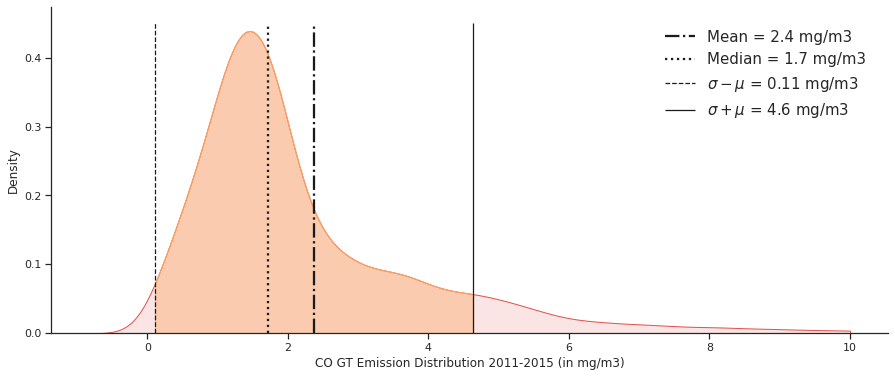

In [27]:
# Plot the Distribution of the Target column CO
fig, axes = plt.subplots(figsize=(15,6))
x = df['CO']
mean = x.mean()
median = x.median()
std = x.std()
left = mean - std
right = mean + std

sns.kdeplot(ax=axes, x=x, shade="fill",
            clip=(-1,10), alpha=0.15, linewidth=1)
sns.kdeplot(ax=axes, x=x, shade="fill",
            clip=(left,right), alpha=0.4, linewidth=1)
height = axes.get_ylim()[1] - 0.01

axes.vlines([mean], 0, height,
                   ls='-.', linewidth=2.25, label=r'Mean = {:.2} mg/m3'.format(mean))
axes.vlines([median], 0, height, 
                   ls=':', linewidth=2.25, label=r'Median = {:.2} mg/m3'.format(median))
axes.vlines([left], 0, height,
                   ls='--', linewidth=1.25, label=r'$\sigma - \mu$ = {:.2} mg/m3'.format(left))
axes.vlines([right], 0, height, 
                   ls='-', linewidth=1.25, label=r'$\sigma + \mu$ = {:.2} mg/m3'.format(right))
axes.legend(loc="best", fontsize = 15, facecolor='white', edgecolor='white', borderpad = 1) 
plt.xlabel("CO GT Emission Distribution 2011-2015 (in mg/m3)")   
plt.show()  

***
#### Write your findings here.
***

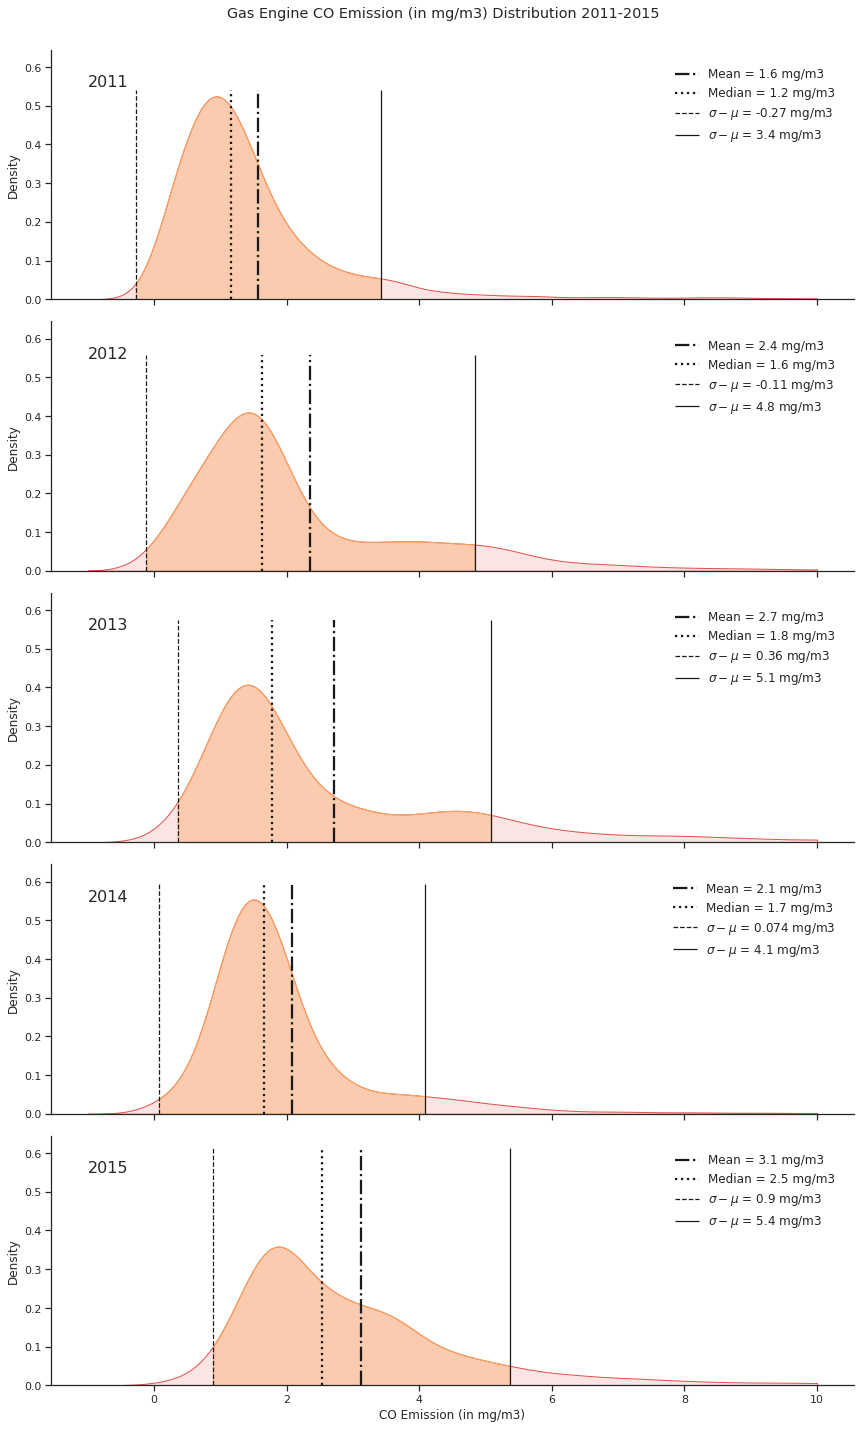

In [28]:
# Plot the Distribution of the Target column CO by the Year
fig, axes = plt.subplots(5, figsize=(12,20),sharey = True, sharex = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) Distribution 2011-2015')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year]['CO']    
    mean = x.mean()
    median = x.median()
    std = x.std()
    left = mean - std
    right = mean + std
    
    sns.kdeplot(ax=axes[index], x=x, shade="fill",
                clip=(-1,10,right), alpha=0.15, linewidth=1)
    sns.kdeplot(ax=axes[index], x=x, shade="fill",
                clip=(left,right), alpha=0.4, linewidth=1)
    height = axes[index].get_ylim()[1] - 0.01
        
    axes[index].vlines([mean], 0, height,
                       ls='-.', linewidth=2.25, label=r'Mean = {:.2} mg/m3'.format(mean))
    axes[index].vlines([median], 0, height, 
                       ls=':', linewidth=2.25, label=r'Median = {:.2} mg/m3'.format(median))
    axes[index].vlines([left], 0, height, 
                       ls='--', linewidth=1.25, label=r'$\sigma - \mu$ = {:.2} mg/m3'.format(left))
    axes[index].vlines([right], 0, height, 
                       ls='-', linewidth=1.25, label=r'$\sigma - \mu$ = {:.2} mg/m3'.format(right))

    
    axes[index].text(-1,0.55,str(year),bbox={'facecolor': 'white', 'alpha': 0, 'pad': 7}, fontsize=16)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    
plt.xlabel("CO Emission (in mg/m3)")   
plt.show()

***
#### Write your findings here.
***

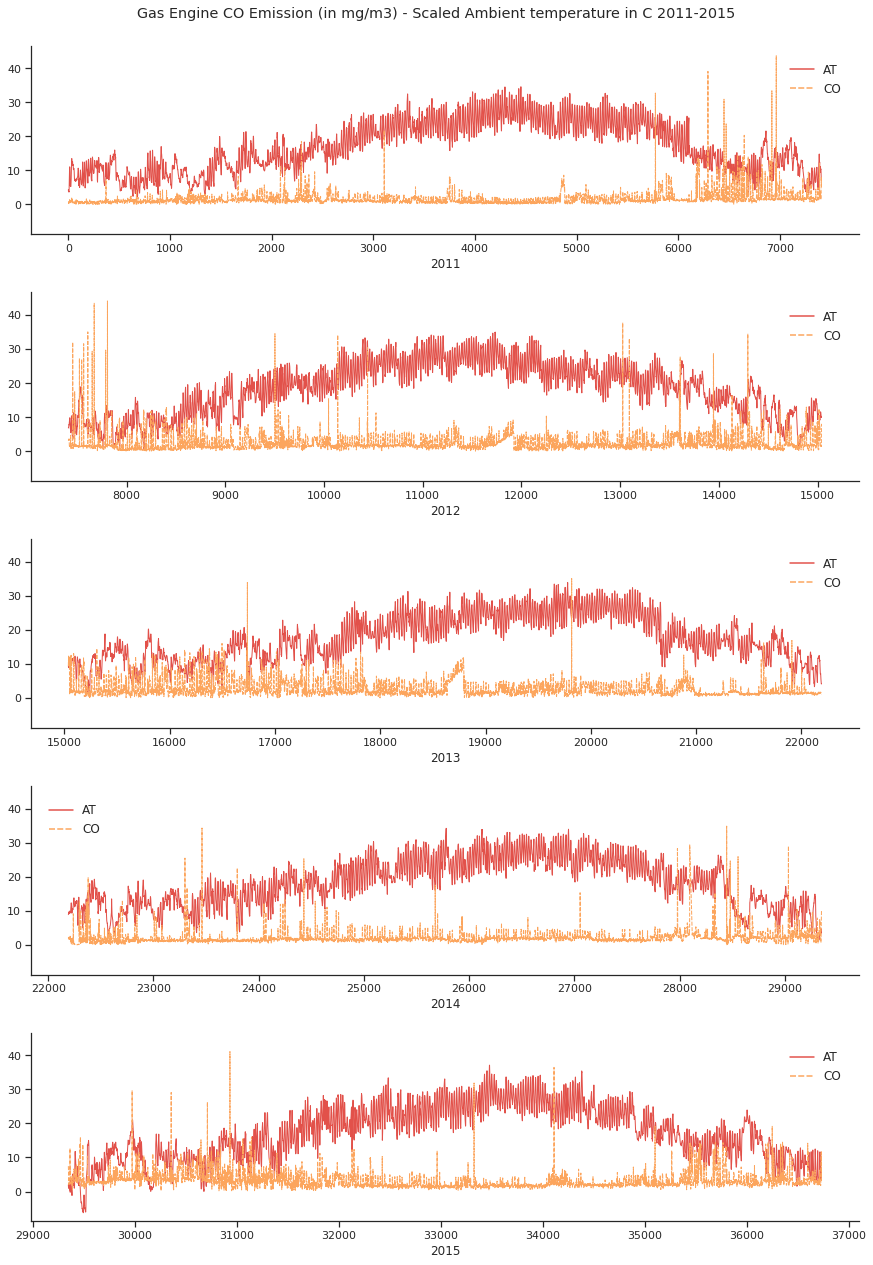

In [29]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[1]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[1],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

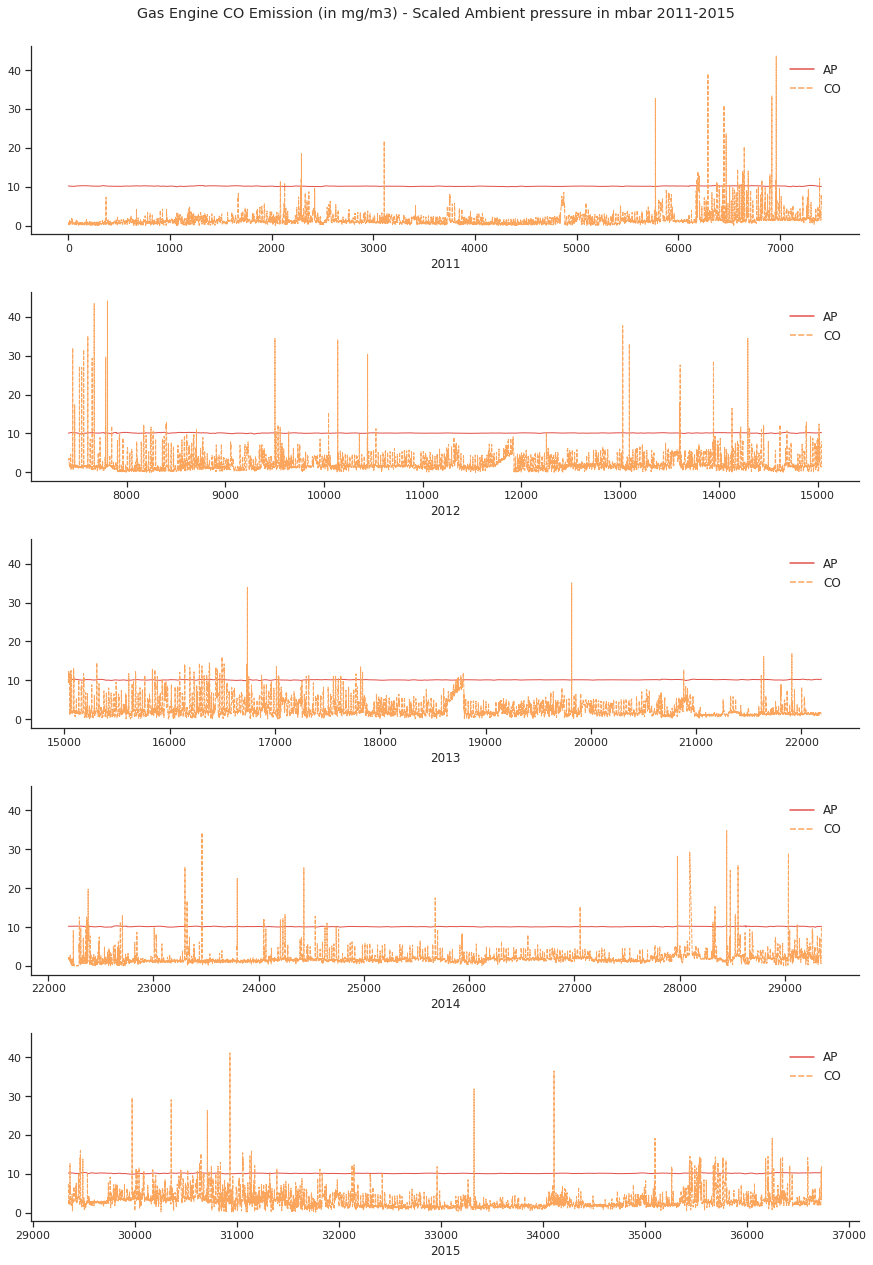

In [30]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[2]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[2],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

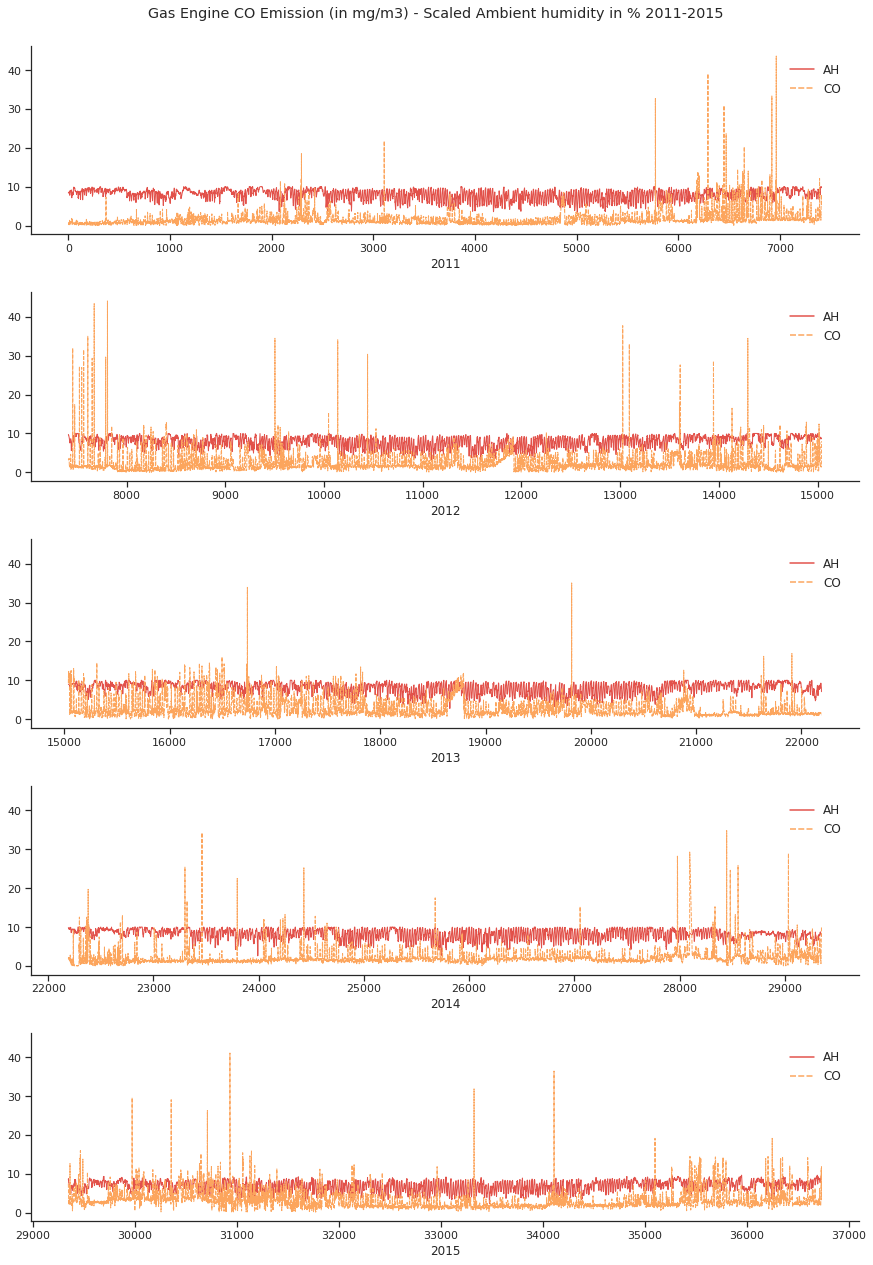

In [31]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[3]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[3],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

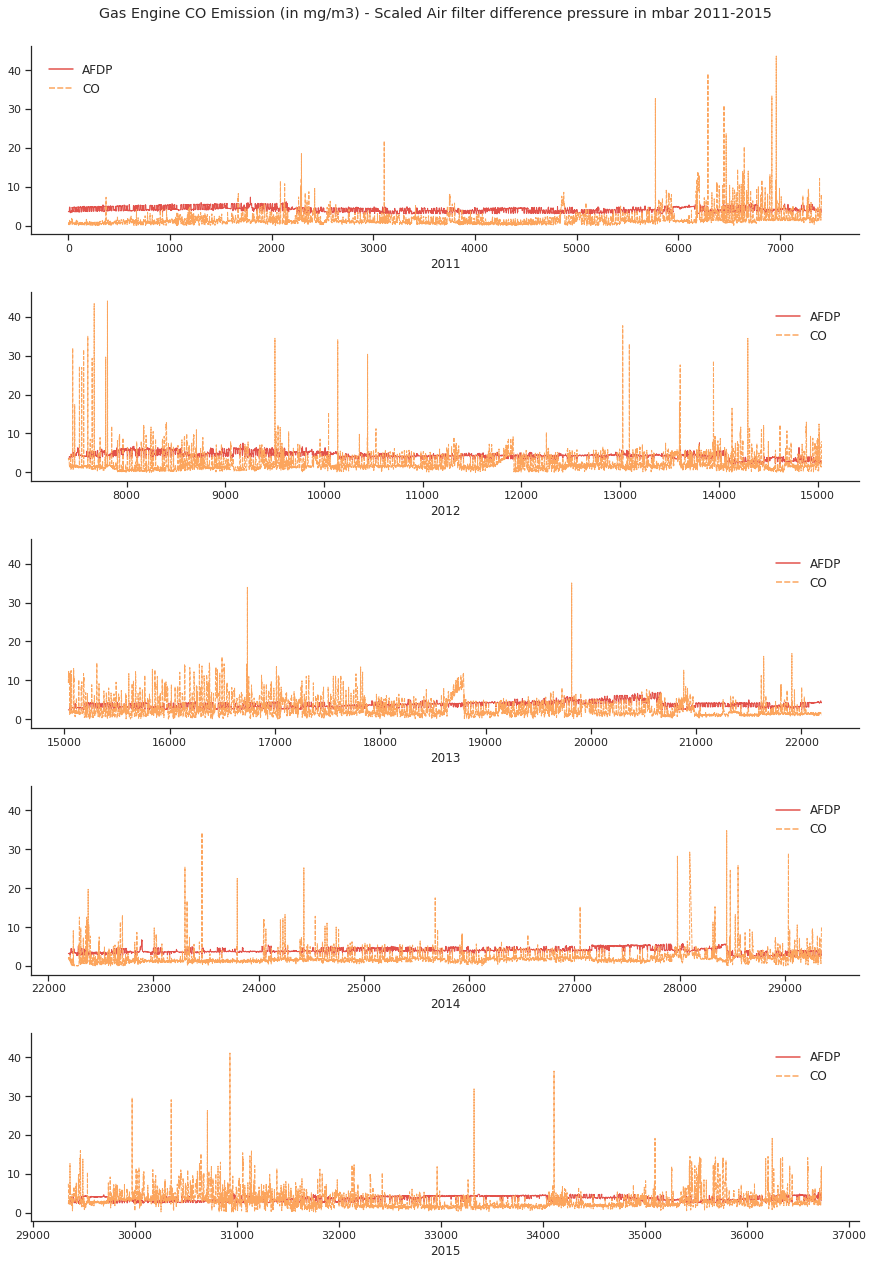

In [32]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[4]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[4],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

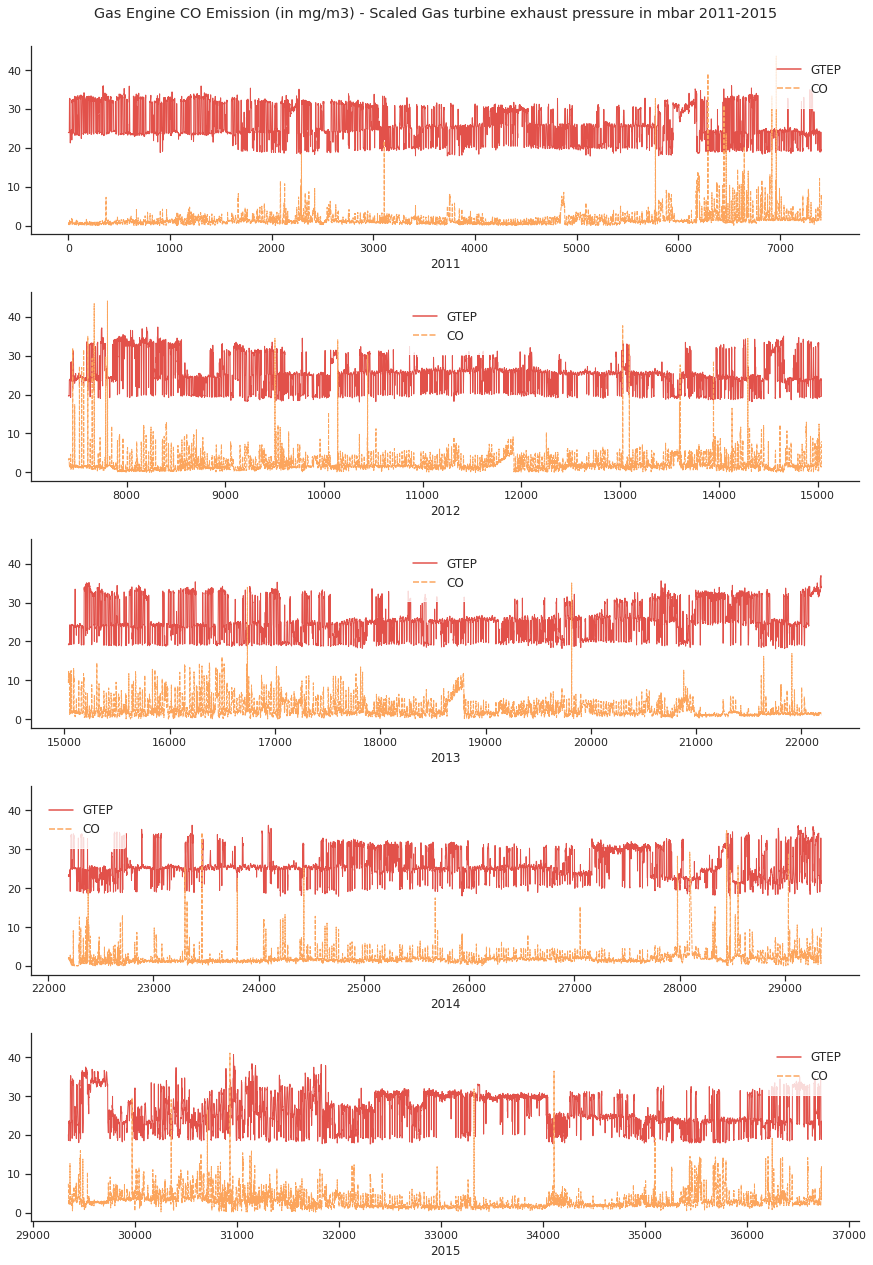

In [33]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[5]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[5],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

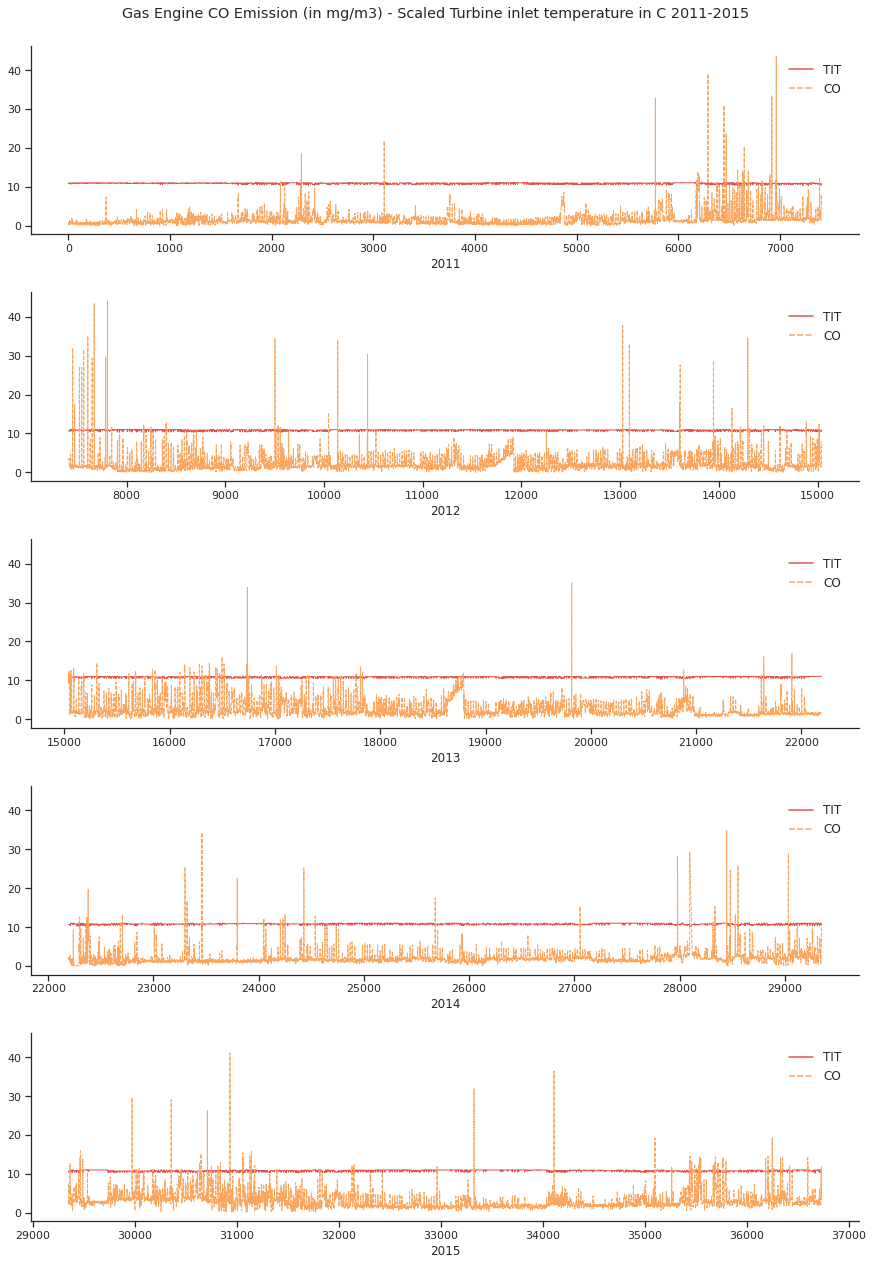

In [34]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[6]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[6],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

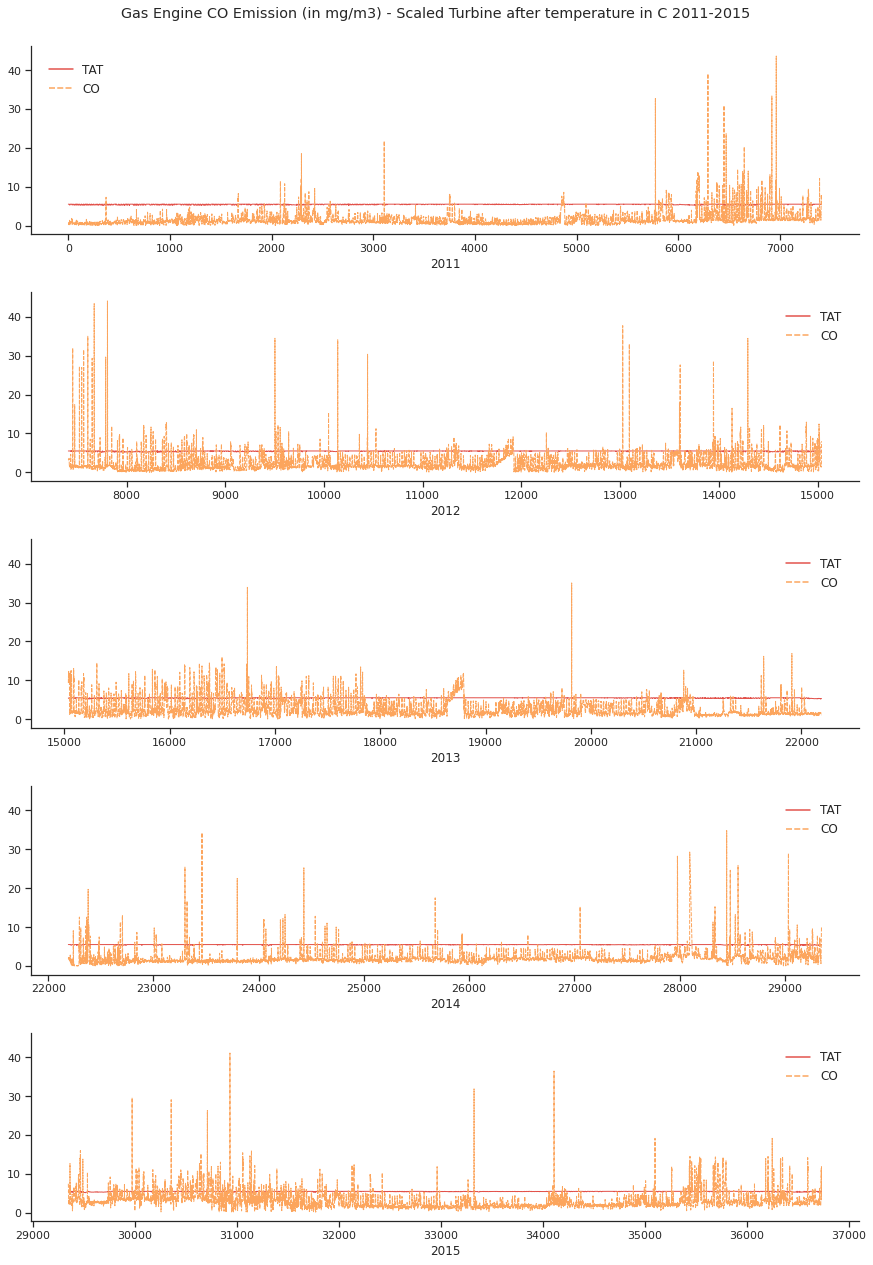

In [35]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[7]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[7],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

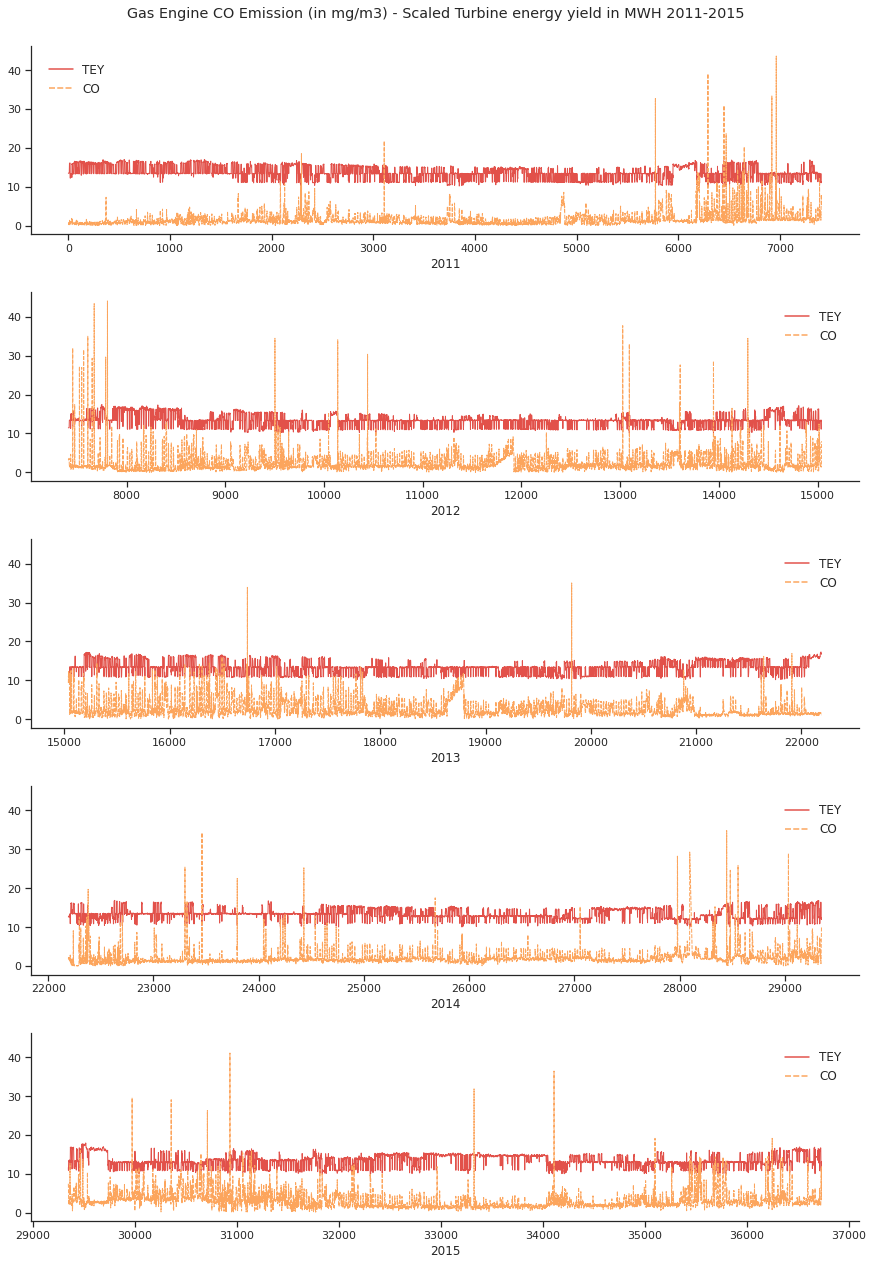

In [36]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[8]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[8],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

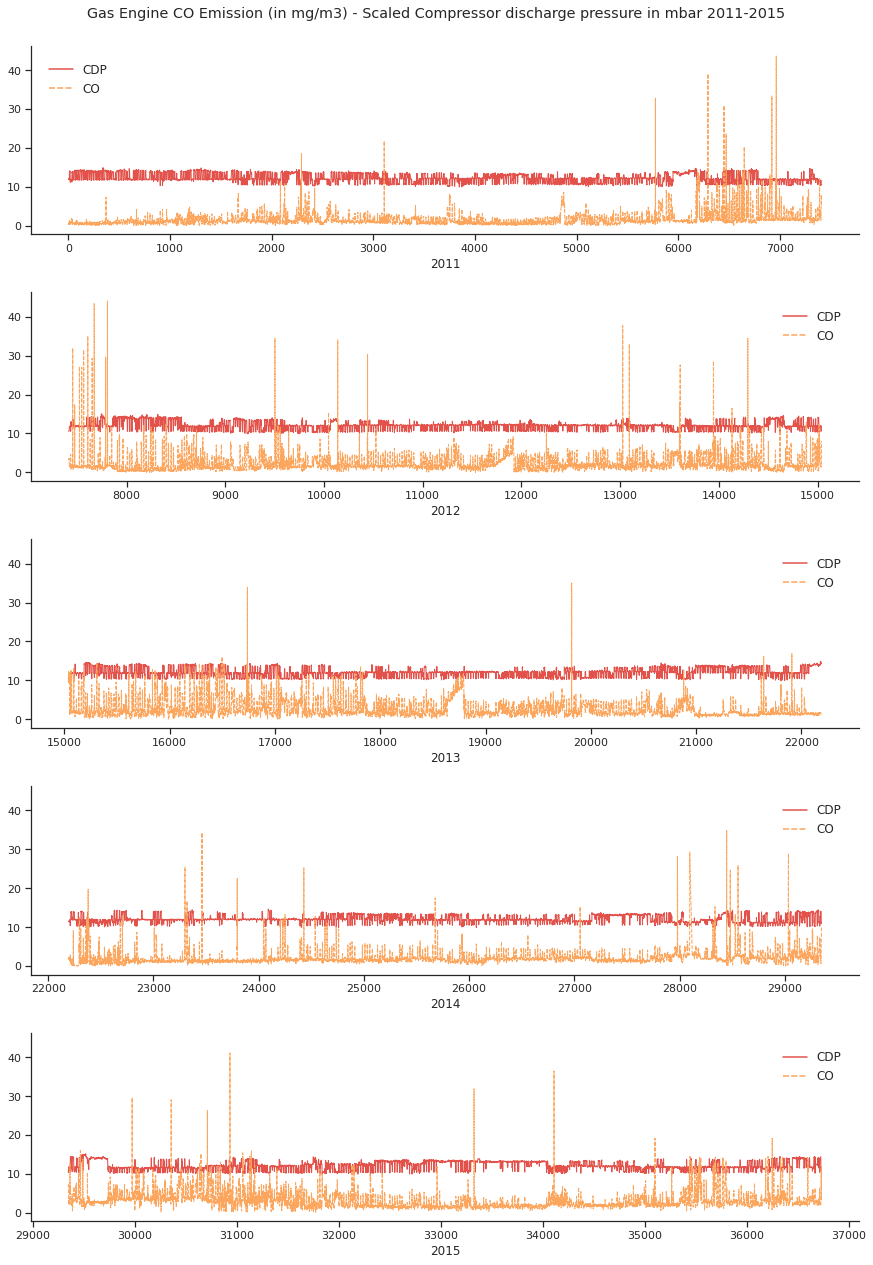

In [37]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[9]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[9],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

In [38]:
# Display the proportion of high values for CO Emission
total_instances = len(df['CO'])
l1,l2,l3 = 0,0,0
for cut_off in range(10,51):
    instances = len(df[df['CO']>cut_off])
    proportion = 100*np.divide(instances,total_instances)
    if proportion <1.0 and l1==0:
        print("=============================== Less than 1.00% ===================================================")
        l1+=1
    elif proportion <0.10 and l2==0:
        print("=============================== Less than 0.10% ===================================================")
        l2+=1
    elif proportion <0.01 and l3==0:
        print("=============================== Less than 0.01% ===================================================")
        l3+=1
    print("Cut-off {} mg/m3 ---- {}/{} Instances ---- Proportion with Emission more than Cut-off {:.2}%".
      format(cut_off,instances,total_instances,proportion))

Cut-off 10 mg/m3 ---- 500/36726 Instances ---- Proportion with Emission more than Cut-off 1.4%
Cut-off 11 mg/m3 ---- 370/36726 Instances ---- Proportion with Emission more than Cut-off 1.0%
=============================== Less than 1.00% ===================================================
Cut-off 12 mg/m3 ---- 236/36726 Instances ---- Proportion with Emission more than Cut-off 0.64%
Cut-off 13 mg/m3 ---- 159/36726 Instances ---- Proportion with Emission more than Cut-off 0.43%
Cut-off 14 mg/m3 ---- 107/36726 Instances ---- Proportion with Emission more than Cut-off 0.29%
Cut-off 15 mg/m3 ---- 83/36726 Instances ---- Proportion with Emission more than Cut-off 0.23%
Cut-off 16 mg/m3 ---- 74/36726 Instances ---- Proportion with Emission more than Cut-off 0.2%
Cut-off 17 mg/m3 ---- 69/36726 Instances ---- Proportion with Emission more than Cut-off 0.19%
Cut-off 18 mg/m3 ---- 64/36726 Instances ---- Proportion with Emission more than Cut-off 0.17%
Cut-off 19 mg/m3 ---- 61/36726 Instances --

In [39]:
# Filter the data based on the cut-off
df_filtered = df[df['CO']<5].copy()

In [40]:
print("Removed {} instances where the CO Emission was more than 27 mg/m3".format(df.shape[0]-df_filtered.shape[0]))

Removed 3200 instances where the CO Emission was more than 27 mg/m3


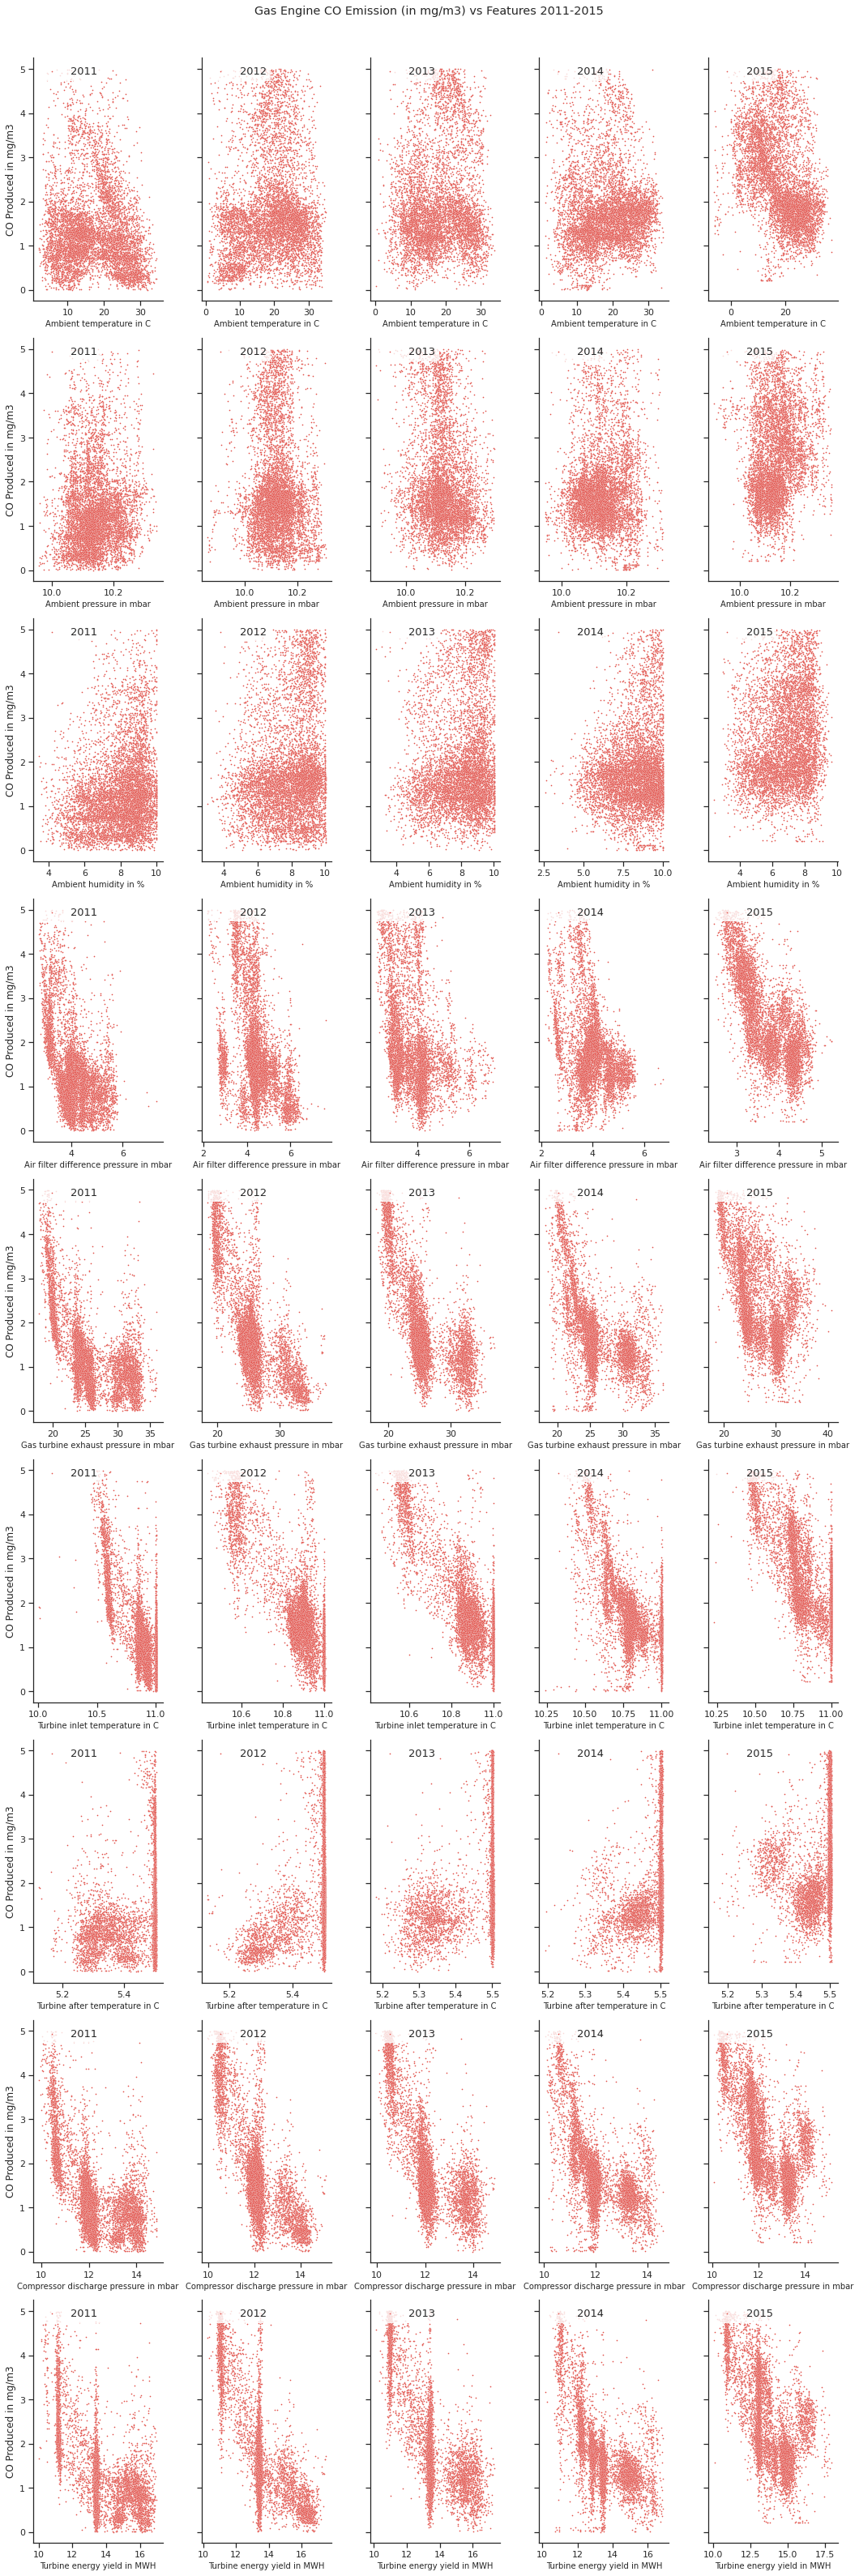

In [41]:
# Plot the Target Column vs Feature Plot by Year

fig, axes = plt.subplots(9,5, figsize=(15,45),sharey = True, sharex = False)
fig.suptitle('Gas Engine CO Emission (in mg/m3) vs Features 2011-2015')
fig.tight_layout(pad=2)
fig.subplots_adjust(top=0.96)
for row,column in enumerate(df[column_info.keys()]):
    for col in range(5):
        year = 2011+col
        sns.scatterplot(ax=axes[row][col], x=df_filtered[df['YEAR'] == year][column],
                        y=df_filtered[df['YEAR'] == year]['CO'], s=3, label=year)
        axes[row][col].set_xlabel(column_info[column],fontsize=10)
        axes[row][col].set_ylabel("CO Produced in mg/m3")
        axes[row][col].legend(loc="upper left", fontsize = 13, facecolor='white', edgecolor='white', borderpad = 0.3) 

plt.show()  

***
#### Write your findings here.
***

<Figure size 432x288 with 0 Axes>

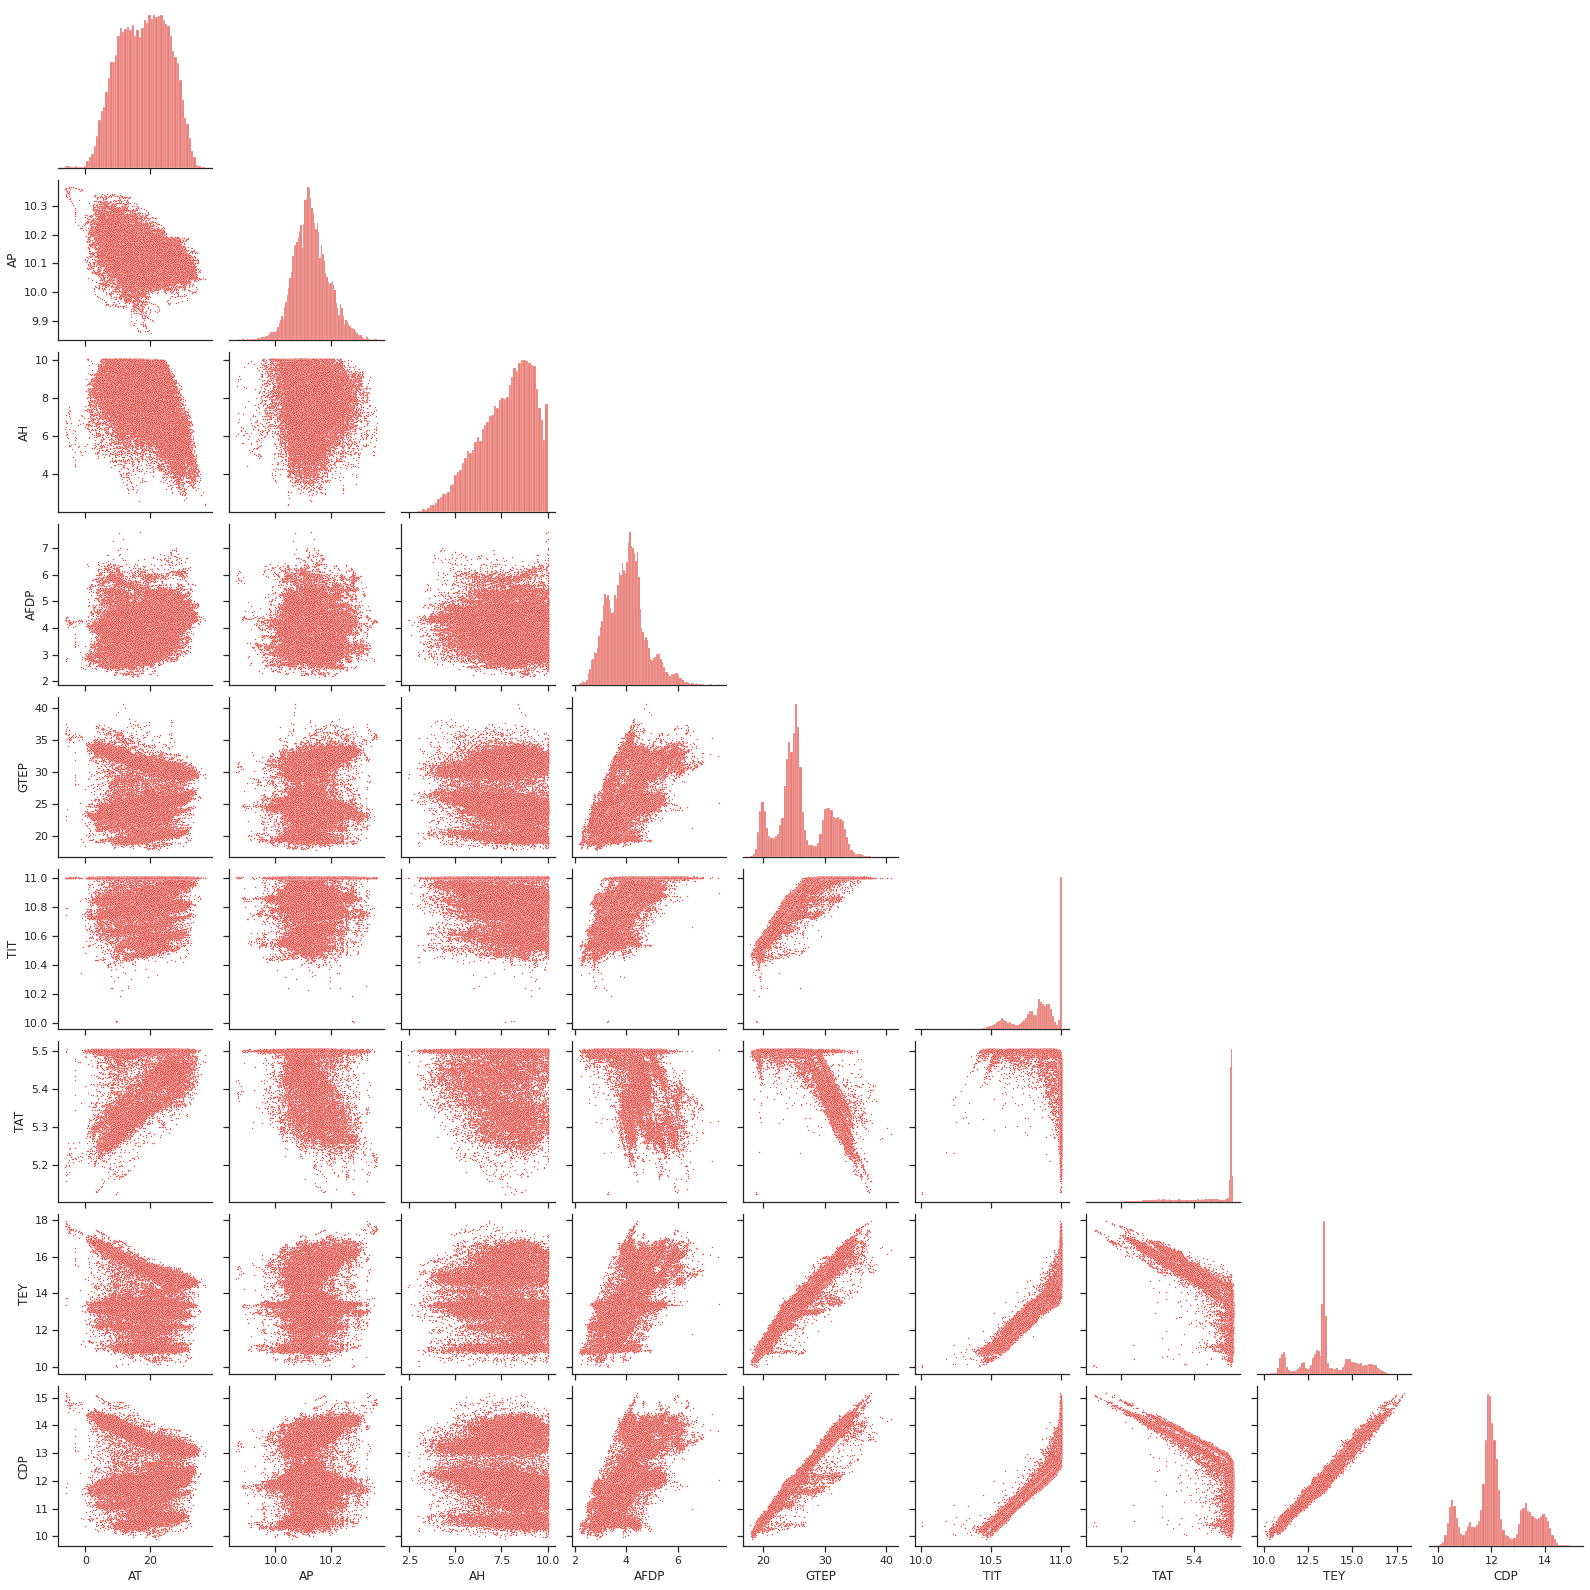

In [42]:
# Plot the Inter-feature interactions
plt.suptitle("Inter-feature interactions")
sns.pairplot(df_filtered.iloc[:,1:-1],plot_kws={"s": 2},corner=True)
plt.show()

***
#### Write your findings here.
***

### Correlation - Pearson

The Pearson correlation coefficient is probably the most widely used measure for linear relationships between two normal distributed variables and thus often just called "correlation coefficient". Usually, the Pearson coefficient is obtained via a Least-Squares fit and a value of 1 represents a perfect positive relation-ship, -1 a perfect negative relationship, and 0 indicates the absence of a relationship between variables.

\begin{equation*}
  r =
  \frac{ \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}) }{%
        \sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
\end{equation*}
<br>
<br>


### Correlation - Spearman


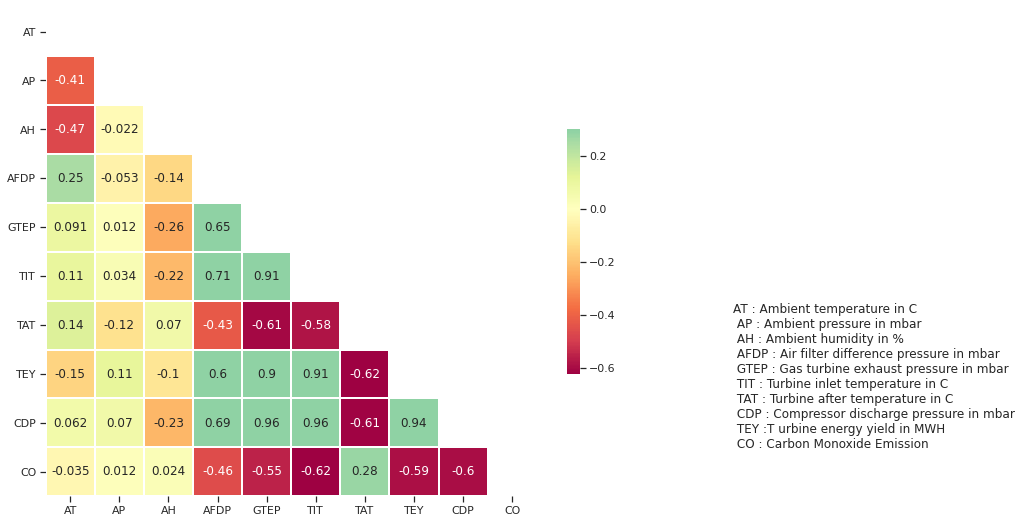

In [43]:
# Get the Correlation matrix
column_info = "AT : Ambient temperature in C \n AP : Ambient pressure in mbar \n AH : Ambient humidity in % \n AFDP : Air filter difference pressure in mbar \n GTEP : Gas turbine exhaust pressure in mbar\n TIT : Turbine inlet temperature in C \n TAT : Turbine after temperature in C\n CDP : Compressor discharge pressure in mbar\n TEY :T urbine energy yield in MWH \n CO : Carbon Monoxide Emission"

corr = df_filtered.iloc[:,1:].corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, axes = plt.subplots(figsize=(11, 9))
sns.heatmap(corr,mask = mask,cmap="Spectral",annot = True, vmax=.3, center=0, linewidths=1, cbar_kws={"shrink": .5})
axes.text(14,9,column_info,bbox={'facecolor': 'white', 'alpha': 0, 'pad': 7}, fontsize=12)
plt.yticks(rotation=0)
plt.show()

In [44]:
# Select upper triangle of correlation matrix
upper = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(np.bool))

In [45]:
upper

AT        AP        AH      AFDP      GTEP       TIT       TAT  \
AT         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
AP   -0.409048       NaN       NaN       NaN       NaN       NaN       NaN   
AH   -0.470031 -0.021558       NaN       NaN       NaN       NaN       NaN   
AFDP  0.249906 -0.052935 -0.144483       NaN       NaN       NaN       NaN   
GTEP  0.091022  0.012347 -0.256038  0.654876       NaN       NaN       NaN   
TIT   0.109084  0.034490 -0.221909  0.707941  0.911694       NaN       NaN   
TAT   0.143493 -0.118797  0.070346 -0.428346 -0.605893 -0.580174       NaN   
TEY  -0.151828  0.113899 -0.101639  0.603707  0.903803  0.912495 -0.624328   
CDP   0.062190  0.070164 -0.225395  0.688315  0.963615  0.955321 -0.614554   
CO   -0.034650  0.012031  0.023551 -0.458522 -0.553517 -0.623164  0.276335   

           TEY       CDP  CO  
AT         NaN       NaN NaN  
AP         NaN       NaN NaN  
AH         NaN       NaN NaN  
AFDP       NaN       NaN NaN  
GTEP       NaN       NaN NaN  
TIT        NaN       NaN NaN  
TAT        NaN       NaN NaN  
TEY        NaN       NaN NaN  
CDP   0.937633       NaN NaN  
CO   -0.590840 -0.597174 NaN

In [46]:
# Find index of feature columns with correlation greater than 0.90
high_cor = [column for column in upper.columns if any(upper[column] >=0.90)]
print("Features with rho > {} are {}".format(0.90,high_cor))

Features with rho > 0.9 are ['GTEP', 'TIT', 'TEY']


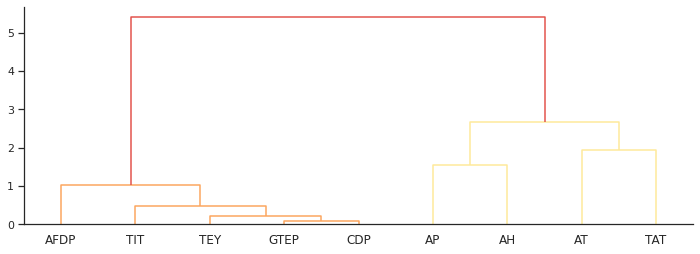

In [47]:
from scipy.cluster import hierarchy
corr_features = df_filtered.iloc[:,1:-1].corr()
fig,ax1 = plt.subplots(1, figsize=(12, 4))
corr_linkage = hierarchy.ward(corr_features)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=df_filtered.iloc[:,1:-1].columns.tolist(), ax=ax1, leaf_rotation=0
)
dendro_idx = np.arange(0, len(dendro['ivl']))
plt.show()

***
#### What is the effect of correlation?

***

#### Linear Independence and Equations of a Surface

> Equation of Line [point = (x,y)]
\begin{equation*}
  ax + by + c = 0
\end{equation*}

> Equation of a Plane [point = (x,y,z)]
\begin{equation*}
  ax + by + cz + d = 0
\end{equation*}

> Equation of a Hyperplane (4 or more dimensions) [point = (x,y,z,w,..)]
\begin{equation*}
  ax + by + cz + dw + e = 0
\end{equation*}

These are all Linear Combinations
\begin{equation*}
  ax + by = -c\\
  ax + by + cz = -d \\
  ax + by + cz + dw = -e
\end{equation*}




#### Matrices and Linear Equation
> How to represent an equation
\begin{equation*}
 \mathbf{A}\mathbf{x} = \mathbf{b}
\end{equation*}
> here A is a matrix and x and b are column vectors


\begin{equation}
A = 
\begin{bmatrix}
a_1 & b_1 & c_1 & d_1\\ 
a_2 & b_2 & c_2 & d_2\\  
a_3 & b_3 & c_3 & d_3\\  
a_4 & b_4 & c_4 & d_4\\  
a_5 & b_5 & c_5 & d_5\\
\end{bmatrix}
\end{equation}

What does it mean for columns to be linearly independent?<br>
If any column of matrix A cannot be written as Linear combination of the other columns

\begin{equation}
\alpha_1
\begin{bmatrix}
a_1\\ 
a_2\\  
a_3\\  
a_4\\  
a_5\\ 
\end{bmatrix} +
 \alpha_2
\begin{bmatrix}
c_1\\ 
c_2\\  
c_3\\  
c_4\\  
c_5\\
\end{bmatrix} = 
\begin{bmatrix}
d_1\\ 
d_2\\  
d_3\\  
d_4\\  
d_5\\
\end{bmatrix} 
\end{equation}



#### Remember Multiplication by a Matrix is a transformation. There are many consequences of this. Because Matrices map information, Inverse of a rectangular matrix cannot exist in traditional sense [Left, right, pseudoinverse].

A Sphere and A Ellipsoid can have the same shadow in either the x plane or y plane ~ a circle but that doesn't mean they are both same. Going from a higher dimension to a lower dimension will **ALWAYS** result in information loss given all the points in that higher dimension space are linearly independent.

If we have a vector **v** with shape nx1, multiplying it by a Matrix **A** with shape nxn  will result in another vector **b** of shape nx1.<br>
There will thus be a Matrix **C** of shape nxn which when multiplied with **b** will give the vector **v**.
<br>
***

In [48]:
df_filtered.head()

YEAR      AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY  \
1  2011  4.2932  10.183  8.4235  3.5709  23.951  10.861  5.5005  13.467   
2  2011  3.9045  10.184  8.4858  3.5828  23.990  10.865  5.5019  13.510   
4  2011  3.7516  10.178  8.5182  3.5781  23.917  10.859  5.5000  13.467   
5  2011  3.8858  10.177  8.3946  3.5824  23.903  10.860  5.4998  13.467   
6  2011  3.6697  10.180  8.4114  3.5804  23.889  10.859  5.5004  13.468   

      CDP       CO  
1  11.892  0.44784  
2  12.042  0.45144  
4  11.910  0.26747  
5  11.868  0.23473  
6  11.877  0.44412

In [49]:
# Create square, square root, logarithmic, power 
for column in column_list[1:-1]:
    df_filtered[column] = df_filtered[column]/10 
    f1 = column + "_sq"
    f2 = column + "_rt"
    f3 = column + "_log"
    f4 = column + "_exp"
    df_filtered[f1] = df_filtered[column].apply(lambda x :np.power(x,2))
    df_filtered[f2] = df_filtered[column].apply(lambda x :np.sqrt(x))
    df_filtered[f3] = df_filtered[column].apply(lambda x :np.log10(x))
    df_filtered[f4] = df_filtered[column].apply(lambda x :np.exp(x))
df_filtered['TCRATIO'] = np.divide(df_filtered['TEY'],df_filtered['CDP'])

In [50]:
print(df_filtered.iloc[0,:])

YEAR        2011.000000
AT             0.429320
AP             1.018300
AH             0.842350
AFDP           0.357090
GTEP           2.395100
TIT            1.086100
TAT            0.550050
TEY            1.346700
CDP            1.189200
CO             0.447840
AT_sq          0.184316
AT_rt          0.655225
AT_log        -0.367219
AT_exp         1.536213
AP_sq          1.036935
AP_rt          1.009109
AP_log         0.007876
AP_exp         2.768484
AH_sq          0.709554
AH_rt          0.917796
AH_log        -0.074507
AH_exp         2.321817
AFDP_sq        0.127513
AFDP_rt        0.597570
AFDP_log      -0.447222
AFDP_exp       1.429164
GTEP_sq        5.736504
GTEP_rt        1.547611
GTEP_log       0.379324
GTEP_exp      10.969295
TIT_sq         1.179613
TIT_rt         1.042161
TIT_log        0.035870
TIT_exp        2.962697
TAT_sq         0.302555
TAT_rt         0.741654
TAT_log       -0.259598
TAT_exp        1.733340
TEY_sq         1.813601
TEY_rt         1.160474
TEY_log        0

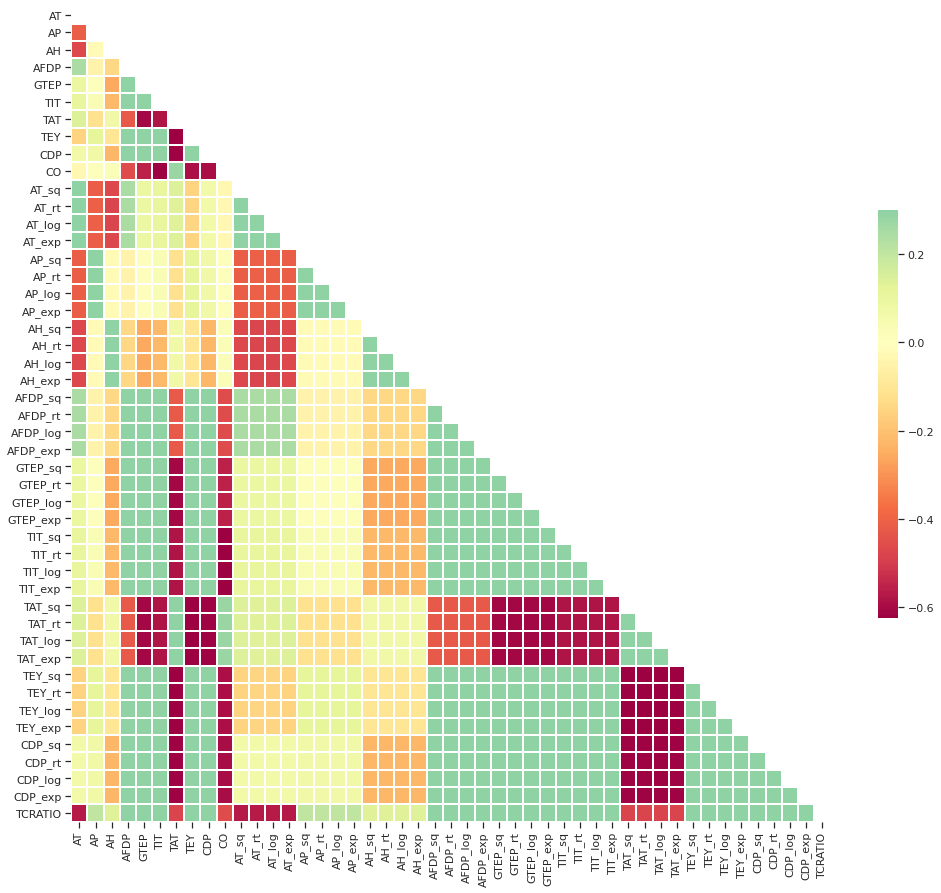

In [51]:
# Get the new Correlation matrix
corr_f = df_filtered.iloc[:,1:].corr(method='spearman')
mask = np.zeros_like(corr_f)
mask[np.triu_indices_from(mask)] = True
fig, axes = plt.subplots(figsize=(17, 15))
sns.heatmap(corr_f,mask = mask,cmap="Spectral", vmax=.3, center=0, linewidths=1, cbar_kws={"shrink": .5})
plt.yticks(rotation=0)
plt.show()

In [52]:
# Find index of feature columns with correlation greater than 0.90
# Select upper triangle of correlation matrix
upper_f = corr_f.where(np.tril(np.ones(corr_f.shape), k=-1).astype(np.bool))
high_cor = [column for column in upper_f.columns if any(upper_f[column] >=0.95)]
print("Features with rho > {} are {}".format(0.95,high_cor))

Features with rho > 0.95 are ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'AT_sq', 'AT_rt', 'AT_log', 'AP_sq', 'AP_rt', 'AP_log', 'AH_sq', 'AH_rt', 'AH_log', 'AFDP_sq', 'AFDP_rt', 'AFDP_log', 'GTEP_sq', 'GTEP_rt', 'GTEP_log', 'GTEP_exp', 'TIT_sq', 'TIT_rt', 'TIT_log', 'TIT_exp', 'TAT_sq', 'TAT_rt', 'TAT_log', 'TEY_sq', 'TEY_rt', 'TEY_log', 'CDP_sq', 'CDP_rt', 'CDP_log']


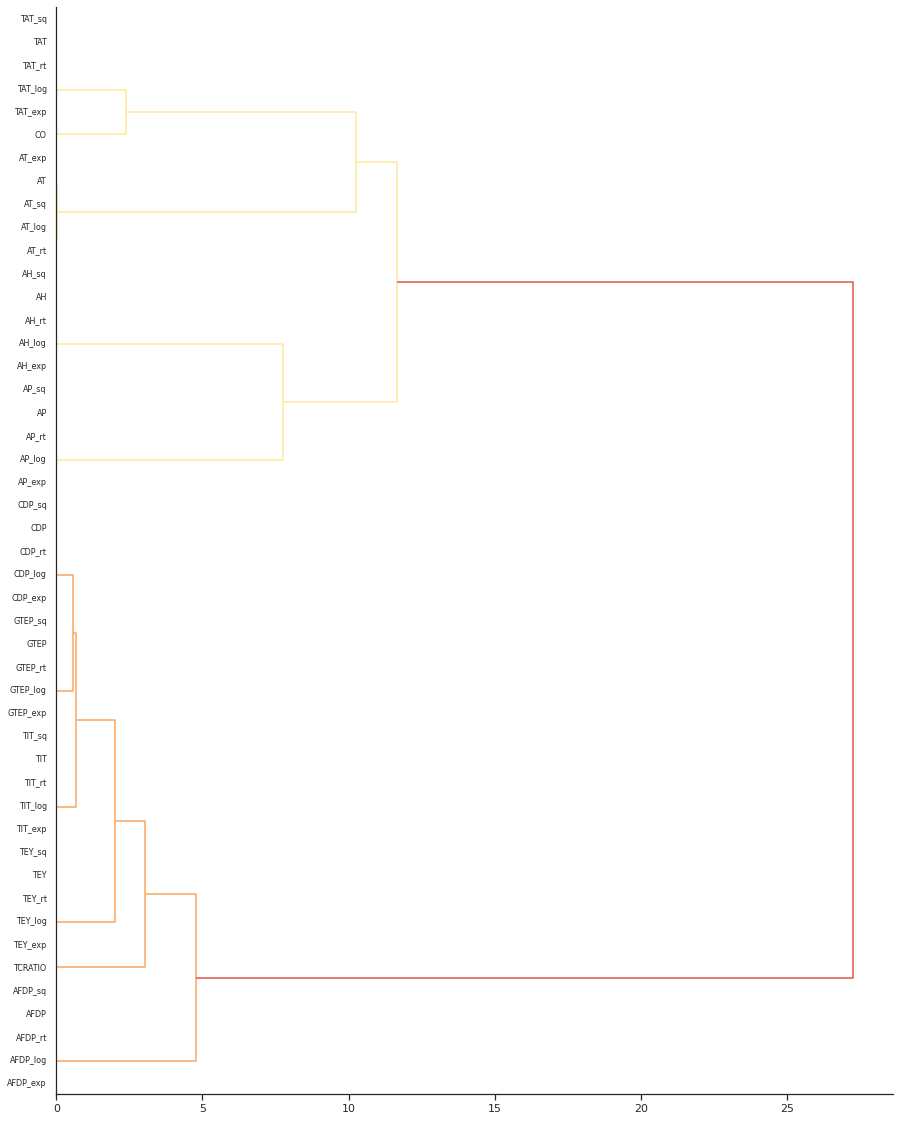

In [53]:
from scipy.cluster import hierarchy
fig,ax1 = plt.subplots(1, figsize=(15,20))
corr_linkage = hierarchy.ward(corr_f)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=corr_f.columns.tolist(), ax=ax1, leaf_rotation=0, orientation='right'
)
dendro_idx = np.arange(0, len(dendro['ivl']))
plt.show()

In [54]:
from collections import defaultdict
cluster_ids = hierarchy.fcluster(corr_linkage,5, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
print("selected features ",selected_features)

selected features  [0, 1, 2, 3, 6]


In [55]:
cluster_id_to_feature_ids

defaultdict(list,
            {4: [0, 10, 11, 12, 13],
             2: [1, 14, 15, 16, 17],
             3: [2, 18, 19, 20, 21],
             1: [3,
              4,
              5,
              7,
              8,
              22,
              23,
              24,
              25,
              26,
              27,
              28,
              29,
              30,
              31,
              32,
              33,
              38,
              39,
              40,
              41,
              42,
              43,
              44,
              45,
              46],
             5: [6, 9, 34, 35, 36, 37]})

In [56]:
final_features = []
for feature in selected_features:
    final_features.append(corr_f.columns.tolist()[feature])
print("Feature list -- ",final_features)

Feature list --  ['AT', 'AP', 'AH', 'AFDP', 'TAT']


In [57]:
X = df_filtered[final_features]
Y = df_filtered['CO']

In [58]:
Y.describe()

count    33526.000000
mean         1.863352
std          1.087104
min          0.000388
25%          1.136025
50%          1.622600
75%          2.335075
max          4.999000
Name: CO, dtype: float64

In [59]:
Y.head()

1    0.44784
2    0.45144
4    0.26747
5    0.23473
6    0.44412
Name: CO, dtype: float64

#### Testing the Temporal Behavior

In [60]:
# Split the Data
x, x_test, y, y_test = train_test_split(X,Y,
                                        test_size = 0.4,
                                        shuffle=False,
                                        random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x,y,
                                                  test_size = 0.1,
                                                  shuffle=True,
                                                  random_state=0)

In [61]:
print("Train Data -- Input Shape  -- {}".format(x_train.shape))
print("Train Data -- Output Shape  -- {}".format(y_train.shape))
print("Validation Data -- Input Shape  -- {}".format(x_val.shape))
print("Validation Data -- Output Shape  -- {}".format(y_val.shape))
print("Test Data -- Input Shape  -- {}".format(x_test.shape))
print("Test Data -- Output Shape  -- {}".format(y_test.shape))

Train Data -- Input Shape  -- (18103, 5)
Train Data -- Output Shape  -- (18103,)
Validation Data -- Input Shape  -- (2012, 5)
Validation Data -- Output Shape  -- (2012,)
Test Data -- Input Shape  -- (13411, 5)
Test Data -- Output Shape  -- (13411,)


In [62]:
x_test.head()

AT      AP       AH     AFDP      TAT
22124  0.34645  1.0216  0.70154  0.41699  0.52624
22125  0.37498  1.0220  0.66008  0.42154  0.52575
22126  0.45211  1.0226  0.57025  0.42083  0.52727
22127  0.51378  1.0232  0.54721  0.41893  0.52842
22128  0.57619  1.0239  0.58757  0.42400  0.52776

In [63]:
rf = RandomForestRegressor()

In [64]:
rf.fit(x_train, y_train)

RandomForestRegressor()

In [65]:
# predict
y_pred_train = rf.predict(x_train)
print('The mse of prediction on train data is: {:.3f}'.format(mean_squared_error(y_train, y_pred_train)))
print('The rmse of prediction on train data is: {:.3f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('The mae of prediction on train data is: {:.3f}'.format(mean_absolute_error(y_train, y_pred_train)))
print('The r square of prediction on train data is: {:.3f}'.format(r2_score(y_train, y_pred_train)))

print("-----------------------------------------------------------------------------------------")
y_pred = rf.predict(x_test)
print('The mse of prediction on test data is: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('The rmse of prediction on test data is: {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('The mae of prediction on test data is: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print('The r square of prediction on test data is: {:.3f}'.format(r2_score(y_test, y_pred)))

The mse of prediction on train data is: 0.081
The rmse of prediction on train data is: 0.284
The mae of prediction on train data is: 0.196
The r square of prediction on train data is: 0.933
-----------------------------------------------------------------------------------------
The mse of prediction on test data is: 1.013
The rmse of prediction on test data is: 1.007
The mae of prediction on test data is: 0.792
The r square of prediction on test data is: 0.013


#### Testing without the Temporal Behavior

In [66]:
# Split the Data
x, x_test, y, y_test = train_test_split(X,Y,
                                        test_size = 0.4,
                                        shuffle=True,
                                        random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x,y,
                                                  test_size = 0.1,
                                                  shuffle=True,
                                                  random_state=0)

In [67]:
print("Train Data -- Input Shape  -- {}".format(x_train.shape))
print("Train Data -- Output Shape  -- {}".format(y_train.shape))
print("Validation Data -- Input Shape  -- {}".format(x_val.shape))
print("Validation Data -- Output Shape  -- {}".format(y_val.shape))
print("Test Data -- Input Shape  -- {}".format(x_test.shape))
print("Test Data -- Output Shape  -- {}".format(y_test.shape))

Train Data -- Input Shape  -- (18103, 5)
Train Data -- Output Shape  -- (18103,)
Validation Data -- Input Shape  -- (2012, 5)
Validation Data -- Output Shape  -- (2012,)
Test Data -- Input Shape  -- (13411, 5)
Test Data -- Output Shape  -- (13411,)


In [68]:
x_test.head()

AT      AP       AH     AFDP      TAT
28027  1.1968  1.0205  0.98414  0.55900  0.53702
24794  1.5536  1.0068  0.83703  0.36970  0.55010
2870   1.6158  1.0132  0.89441  0.35904  0.55004
9533   1.5832  1.0125  0.80631  0.45033  0.54977
12204  2.1186  1.0082  0.93010  0.42418  0.54998

In [69]:
rf = RandomForestRegressor()

In [70]:
rf.fit(x_train, y_train)

RandomForestRegressor()

In [71]:
# predict
y_pred_train = rf.predict(x_train)
print('The mse of prediction on train data is: {:.3f}'.format(mean_squared_error(y_train, y_pred_train)))
print('The rmse of prediction on train data is: {:.3f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('The mae of prediction on train data is: {:.3f}'.format(mean_absolute_error(y_train, y_pred_train)))
print('The r square of prediction on train data is: {:.3f}'.format(r2_score(y_train, y_pred_train)))

print("-----------------------------------------------------------------------------------------")
y_pred = rf.predict(x_test)
print('The mse of prediction on test data is: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('The rmse of prediction on test data is: {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('The mae of prediction on test data is: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print('The r square of prediction on test data is: {:.3f}'.format(r2_score(y_test, y_pred)))

The mse of prediction on train data is: 0.080
The rmse of prediction on train data is: 0.284
The mae of prediction on train data is: 0.201
The r square of prediction on train data is: 0.932
-----------------------------------------------------------------------------------------
The mse of prediction on test data is: 0.578
The rmse of prediction on test data is: 0.760
The mae of prediction on test data is: 0.538
The r square of prediction on test data is: 0.513


In [72]:
tuned_rf = RandomForestRegressor(bootstrap=True, max_depth=100, max_features=3, n_estimators= 300)
tuned_rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=100, max_features=3, n_estimators=300)

In [73]:
# predict
y_pred_train = tuned_rf.predict(x_train)
print('The mse of prediction on train data is: {:.3f}'.format(mean_squared_error(y_train, y_pred_train)))
print('The rmse of prediction on train data is: {:.3f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('The mae of prediction on train data is: {:.3f}'.format(mean_absolute_error(y_train, y_pred_train)))
print('The r square of prediction on train data is: {:.3f}'.format(r2_score(y_train, y_pred_train)))

print("-----------------------------------------------------------------------------------------")
y_pred = tuned_rf.predict(x_test)
print('The mse of prediction on test data is: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('The rmse of prediction on test data is: {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('The mae of prediction on test data is: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print('The r square of prediction on test data is: {:.3f}'.format(r2_score(y_test, y_pred)))

The mse of prediction on train data is: 0.078
The rmse of prediction on train data is: 0.279
The mae of prediction on train data is: 0.199
The r square of prediction on train data is: 0.934
-----------------------------------------------------------------------------------------
The mse of prediction on test data is: 0.570
The rmse of prediction on test data is: 0.755
The mae of prediction on test data is: 0.536
The r square of prediction on test data is: 0.519


**
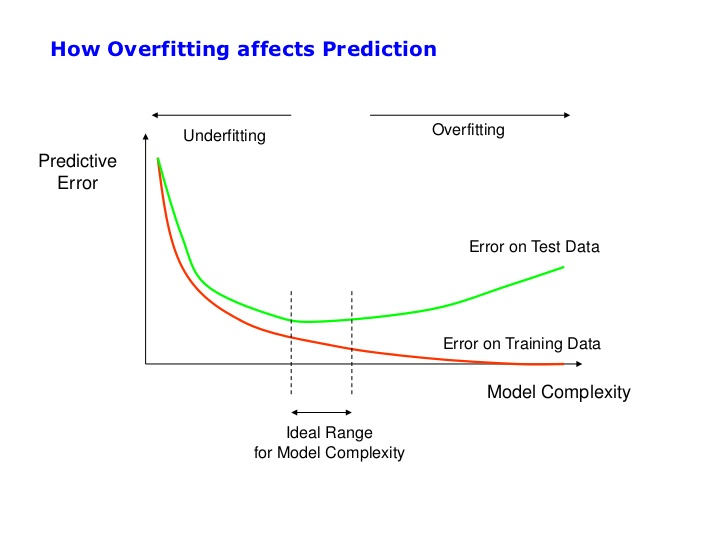
**

### Resources for you

> [pandas](https://pandas.pydata.org/docs/user_guide/index.html)
>
> [numpy](https://numpy.org/learn/)
>
> [sklearn](https://scikit-learn.org/stable/user_guide.html)
>
> [statistics courses](https://online.stat.psu.edu/statprogram/)
>
> [shapley](https://github.com/slundberg/shap)
>
> [Approaching (Almost) Any Machine Learning Problem by Abhishek Thakur](https://www.amazon.in/Approaching-Almost-Machine-Learning-Problem-ebook/dp/B089P13QHT)
>
> [Cassie's youtube channel](https://www.youtube.com/channel/UCbOX--VOebPe-MMRkatFRxw)
>
> [IBM courses for the Data Science Track](https://www.coursera.org/ibm)